# 1-D Framework
<p>This notebook represents the cumulative and current state of the 1D functions that I have yet created.</p>

In [165]:
import numpy as np
import matplotlib.pyplot as plt

class FlowModel:
    
    def __init__(self, length = 10, numElements = 10, conductivity = .1, diffusivity = .05, dispersivity = .1, timeDelta = 1, porosity = .25):
        self.length = length
        self.numElements = numElements
        self.conductivity = conductivity
        self.heads = np.zeros(numElements)
        self.scale = length/numElements
        self.plt = plt
        self.diffusivity = diffusivity
        self.dispersivity = dispersivity
        self.solutePeak = 0   # Accurate tracker for the solute peak
        self.concentrations = np.zeros(numElements)
        self.totalSolute = 0
        self.totalWater = 0
        self.timeDelta = timeDelta
        self.porosity = porosity
        self.pointConstants = []
        self.queueChanges = []
        
        
    # Flow Functions
    #---------------------------------------------------------------------------
    def flow(self, runs = 1, debug = False, trackChanges = False):
        '''
        Normal 1D flow equation
        '''
        if trackChanges:
            self.queueChanges = []
        
        for i in range(runs):
            for el in self.pointConstants:
                self.heads[el[0]] = el[1]
            queue = np.zeros(self.numElements)
            queue[:-1] += self.timeDelta*self.conductivity*(self.heads[1: ] - self.heads[:-1])/self.scale
            queue[1: ] += self.timeDelta*self.conductivity*(self.heads[:-1] - self.heads[1: ])/self.scale
            queue = np.round(queue,5)
            self.heads += queue
            
            if debug:
                print("Queue:")
                print(queue)
            
            if trackChanges:
                self.queueChanges.append(np.sum(np.abs(queue)))
            del queue
        
        for i in range(self.numElements):
            if self.heads[i] < 0:
                self.heads[i] = 0

        if trackChanges:
            self.queueChanges = np.array(self.queueChanges)
            
    def flowToSteadyState(self, tolerance = .001, trackChanges = False, printValues = True, returnCounter = False):
        '''
        Flows to steady state, which is measured by the difference in the queue
        change being less than or equal to a given tolerance. The queue change will
        decrease asymptotically towards zero, ignoring any input and output and using
        the boundary conditions.
        '''
        change = 10000.0
        pChange = 0
        previous = 10000000
        counter = 0
        while change > tolerance:
            if not isinstance(change, float):
                break
            for el in self.pointConstants:
                self.heads[el[0]] = el[1]
            queue = np.zeros(self.numElements)
            queue[:-1] += self.timeDelta*self.conductivity*(self.heads[1: ] - self.heads[:-1])/self.scale
            queue[1: ] += self.timeDelta*self.conductivity*(self.heads[:-1] - self.heads[1: ])/self.scale
            queue = np.round(queue,5)
            self.heads += queue
            current = np.sum(np.abs(queue))
            pChange = change
            change = float(abs(previous - current))
            print(change)
            previous = current
            counter += self.timeDelta
            
            
        if printValues:
            print("Steady state reached:")
            print("Time taken: {}".format(counter))
            print("Final difference: {}".format(change))
            print("Penultimate change: {}".format(pChange))
            
        if returnCounter:
            return counter
        
    def averageVelocity(self):
        '''
        Determines the average velocity for each element of the array
        - Porosity is constant, so the bulk of this is just determining q
        - This should be 1 shorter than numElements
        '''
        q = np.zeros(self.numElements)
        q += self.conductivity*(self.heads[:-1] - self.heads[1: ])*(1/self.scale)
        return q/self.porosity
    

    # Solute Transport
    #---------------------------------------------------------------------------
    def advection(self):
        '''
        Models advection, the transport of solute with the bulk fluid motion
        - Follows the motion of the largest
        '''
        new = self.solutePeak + self.averageVelocity()
        if new > int(self.solutePeak):
            queue = np.zeros(self.numElements)   # Need to determine the direction of flow, because this flows to the right,
            queue[:-1] += (self.concentrations[:-1] - self.concentrations[1: ])  # but it isn't necessarily that direction.
            queue[1: ] += (self.concentrations[1: ] - self.concentrations[:-1])
            self.concentrations += queue
            del queue
            
    def forceAdvection(self):
        queue = np.copy(self.concentrations[:-1])
        self.concentrations[:-1] -= queue
        self.concentrations[1:] += queue
        del queue
    
    def diffusion(self, runs = 1):
        for i in range(runs):
            queue = self.concentrations*self.diffusivity*self.timeDelta
            self.concentrations -= 2*queue
            self.concentrations[:-1] += queue[1: ]
            self.concentrations[1: ] += queue[:-1]
    
    def forceDiffusion(self, runs = 1):
        for i in range(runs):
            queue = self.concentrations*self.diffusivity
            self.concentrations -= 2*queue
            self.concentrations[:-1] += queue[1: ]
            self.concentrations[1: ] += queue[:-1]

    def dispersion(self):
        dispersiveCoefficients = self.dispersivity*self.averageVelocity()
        
        
    # Plotting things
    #---------------------------------------------------------------------------
    def plotHeads(self):
        self.plt.plot(np.linspace(0,self.length,self.numElements),self.heads)
        self.plt.xlim(0,self.length)
        self.plt.xlabel("Length")
        self.plt.ylabel("Hydraulic head")
        self.plt.title("Hydraulic head over the model")
        self.plt.show()
        
    def plotConc(self):
        self.plt.plot(np.linspace(0,self.length,self.numElements),self.concentrations)
        self.plt.xlim(0,self.length)
        self.plt.xlabel("X position")
        self.plt.ylabel("Solute Concentration")
        self.plt.title("Solute Concentration in the model")
        self.plt.ylim(0,1)
        self.plt.xlim(0, self.length)
        self.plt.show()
        
    def showQueueChanges(self):
        '''Plots a graph of how the queue changes over some iterations'''
        self.plt.plot(self.queueChanges)
        self.plt.xlabel("Iteration")
        self.plt.ylabel("Total Queue")
        self.plt.title("Queue change over time")
        self.plt.show()
        
    def showQueueAcceleration(self):
        '''Show a graph of how the queue change changes over time over time'''
        acceleration = np.abs(self.queueChanges[1:]-self.queueChanges[:-1])
        self.plt.plot(acceleration)
        self.plt.xlabel("Iterations")
        self.plt.ylabel("Change in the queue change")
        self.plt.title("Change in the queue change over iterations")
        self.plt.show()
        
    # Determining some actual useful things
    #---------------------------------------------------------------------------
    def soluteEvolution(self, curves = 5, time = 10):
        '''
        Runs solute transport evolution.
        - Plots a given amount of graphs for solute concentration over a given time.
        - At the moment, it does not contain dispersion
        '''
        plots = []
        step = int(time/curves)
        j = step
        alpha_step = .8/curves
        for i in range(time):
            mod.diffusion()
            mod.forceAdvection()
            if j == step:
                plots.append(np.copy(self.concentrations))
                j = 0
            else:
                j += 1
        for i in range(len(plots)):
            self.plt.plot(np.linspace(0,self.length,self.numElements),plots[i], color = 'blue', alpha = .2 + i*alpha_step)
        self.plt.xlabel("Horizontal position")
        self.plt.ylabel("Solute concentration")
        self.plt.xlim(0,self.length)
        self.plt.ylim(0,1)
        self.plt.title("Solute concentration over time")
        self.plt.show()
        
    
    # Printing information and things
    #---------------------------------------------------------------------------     
    def __str__(self):
        print("Flow Model")
        print("--------------")
        print("Number of elements:",self.numElements)
        print("Model Length:",self.length, "meters")
        print("Scale", self.scale, ("meters per element"))
        print("Hydraulic conductivity:", self.conductivity)
        return "--------------"
    
    def checkSums(self):
        if self.totalSolute != self.getSoluteTotal():
            print('Something wrong with solute:')
            print("Expected: ", self.soluteTotal)
            print("Current: ", self.getSoluteTotal())
    
    
    # Some ease of use stuff here
    #---------------------------------------------------------------------------
    def setDefaults(self):
        self.heads[0] = 1
        self.heads[-1] = 0
        self.pointConstants.append((0,1))
        self.pointConstants.append((self.numElements-1,0))
        self.concentrations[int(self.length/2)] = 1
        self.totalSolute = np.sum(self.concentrations)
        self.totalWater = np.sum(self.heads)
        
    def getSoluteTotal(self):
        return np.sum(self.concentrations)
    
    def getWaterTotal(self):
        return np.sum(self.heads)

## Testing the model

Change: 
Change: 
Steady state reached:
Time taken: 0.08333333333333333
Final difference: 0.0
Penultimate change: 9999999.99916


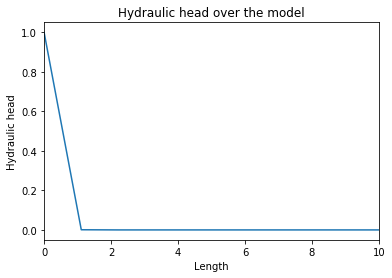

In [164]:
mod = FlowModel(numElements = 10, length = 10, conductivity = .01, timeDelta = 1/24)
mod.setDefaults()

'''
toleranceTest = []

for i in range(1,6):
    mod = FlowModel(numElements = i*10)
    mod.setDefaults()
    val = mod.flowToSteadyState(printValues = False, returnCounter = True)
    toleranceTest.append(val)
plt.plot(toleranceTest)
plt.show()
'''
#mod.flow(10000)
mod.flowToSteadyState(tolerance = .000001)
mod.plotHeads()


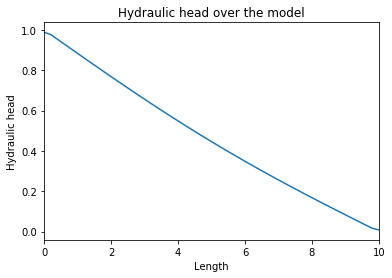

In [99]:
mod.flow(200)
mod.plotHeads()